In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
np.random.seed(7)

In [3]:
dat=np.random.randint(1,3,size=(3,4))

In [10]:
#ahora cargamos datos de contaminacion en pollution.csv
data=pd.read_csv("pollution.csv",index_col=[0],parse_dates=True)


In [11]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


In [19]:
#ahora separamos los datos para el procesamiento
#problema: Hallar la precipitacion del dia siguiente,usando los datos recopilados del dia anterior

train=data[:"2014-01-01 00:00:00"]
test=data["2014-01-01 00:00:00":]

train_index=train.index
test_index=test.index

In [22]:
n_future=1
n_past=1
def create_dataset(data,n_past=1,n_future=1):
    X,y=[],[]
    for i in range(n_past,len(data)-n_future+1):
        X.append(data[i-n_past:i,:])
        y.append(data[i+n_future-1:i+n_future,0])
    return np.array(X),np.array(y)

In [27]:
#escalamiento de datos en tuberias Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [42]:
numerical_features=['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
numerical_transformer=Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",MinMaxScaler(feature_range=(0,1)))
])

categorical_features=["cbwd"]
categorical_transformer=Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(drop="if_binary"))
])


In [43]:
transformer=ColumnTransformer([
    ("numerical_transform",numerical_transformer,numerical_features),
    ("categorical_transform",categorical_transformer,categorical_features)
],
 remainder="passthrough"
)

In [46]:
transformer.fit(train);
if transformer.sparse_output_:
    train=transformer.transform(train).toarray()
    test=transformer.transform(test).toarray()
else:
    train=transformer.transform(train) 
    test=transformer.transform(test)

In [48]:
#transformacion de forma de datos
n_future=1 #numero de horas que queremos predecir en el futuro
n_past=24   #numero de horas que usaremos para la prediccion

x_train,y_train=create_dataset(train,n_past,n_future)
x_test,y_test=create_dataset(test,n_past,n_future)

In [49]:
x_train.shape

(35041, 24, 11)

In [50]:
y_train.shape

(35041, 1)

In [52]:
y_test

array([[0.14486922],
       [0.17102616],
       [0.1750503 ],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]])

In [54]:
#implementamos la red neuronal
import tensorflow as tf
from keras.utils import plot_model
from sklearn import set_config


In [57]:
set_config(display="diagram")

In [58]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical_transform',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is',
                                  'Ir']),
                                ('categorical_transform',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['cbwd'])])

In [65]:
def build_model():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(n_past,x_train.shape[2]),name="INPUT"))
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,name="LSTMx64"))
    model.add(tf.keras.layers.Dropout(0.2,name="DROPOUTx1"))
    model.add(tf.keras.layers.LSTM(units=32,return_sequences=False,name="LSTMx32"))
    model.add(tf.keras.layers.Dropout(0.2,name="DROPOUTx2"))
    model.add(tf.keras.layers.Dense(1,name="OUTPUT"))
    #compilacion del modelo
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"]) #se escoje RMSprop por mayor precision en RNN
    return model
    

In [66]:
#la fase de entrenamiento del modelo
model_lstm=build_model()
history=model_lstm.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
876/876 [==============================] - 21s 24ms/step - loss: 0.0028 - mae: 0.0359 - val_loss: 9.7147e-04 - val_mae: 0.0228
Epoch 2/10
876/876 [==============================] - 19s 22ms/step - loss: 0.0012 - mae: 0.0226 - val_loss: 5.2202e-04 - val_mae: 0.0143
Epoch 3/10
876/876 [==============================] - 20s 22ms/step - loss: 0.0010 - mae: 0.0196 - val_loss: 4.8870e-04 - val_mae: 0.0149
Epoch 4/10
876/876 [==============================] - 20s 23ms/step - loss: 9.5201e-04 - mae: 0.0184 - val_loss: 4.6035e-04 - val_mae: 0.0137
Epoch 5/10
876/876 [==============================] - 19s 22ms/step - loss: 9.1006e-04 - mae: 0.0179 - val_loss: 4.3283e-04 - val_mae: 0.0122
Epoch 6/10
876/876 [==============================] - 20s 22ms/step - loss: 8.7659e-04 - mae: 0.0174 - val_loss: 4.3157e-04 - val_mae: 0.0129
Epoch 7/10
876/876 [==============================] - 19s 22ms/step - loss: 8.7926e-04 - mae: 0.0173 - val_loss: 4.6360e-04 - val_mae: 0.0134
Epoch 8/10
876/876

In [70]:
def plot_metrics(history):
    epochs=range(1,len(history["mae"])+1)
    plt.plot(epochs,history["mae"],"bo-",label=" MAE train")
    plt.plot(epochs,history["val_mae"],"ro-",label=" MAE test")
    plt.xlabel("epochs")
    plt.ylabel("MAE: Error absoluto Medio")
    plt.legend(loc="best")
    plt.show()

def plot_loss(history):
    epochs=range(1,len(history["loss"])+1)
    plt.plot(epochs,history["loss"],"bo-",label=" loss train")
    plt.plot(epochs,history["val_loss"],"ro-",label=" loss test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")
    plt.show()

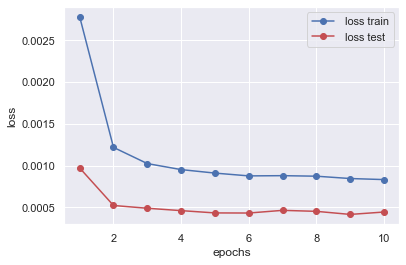

In [71]:
#no hay evaluacion de metrics
plot_loss(history.history)

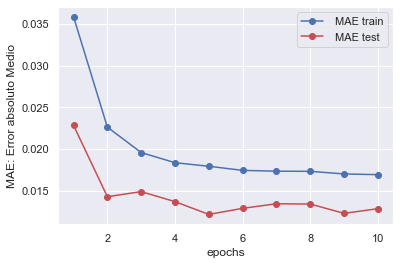

In [72]:
plot_metrics(history.history)

In [73]:
model_lstm.evaluate(x_test,y_test)

273/273 [==============================] - 2s 7ms/step - loss: 5.6298e-04 - mae: 0.0136


[0.0005629800725728273, 0.013572477735579014]

In [75]:
y_pred=model_lstm.predict(x_test)

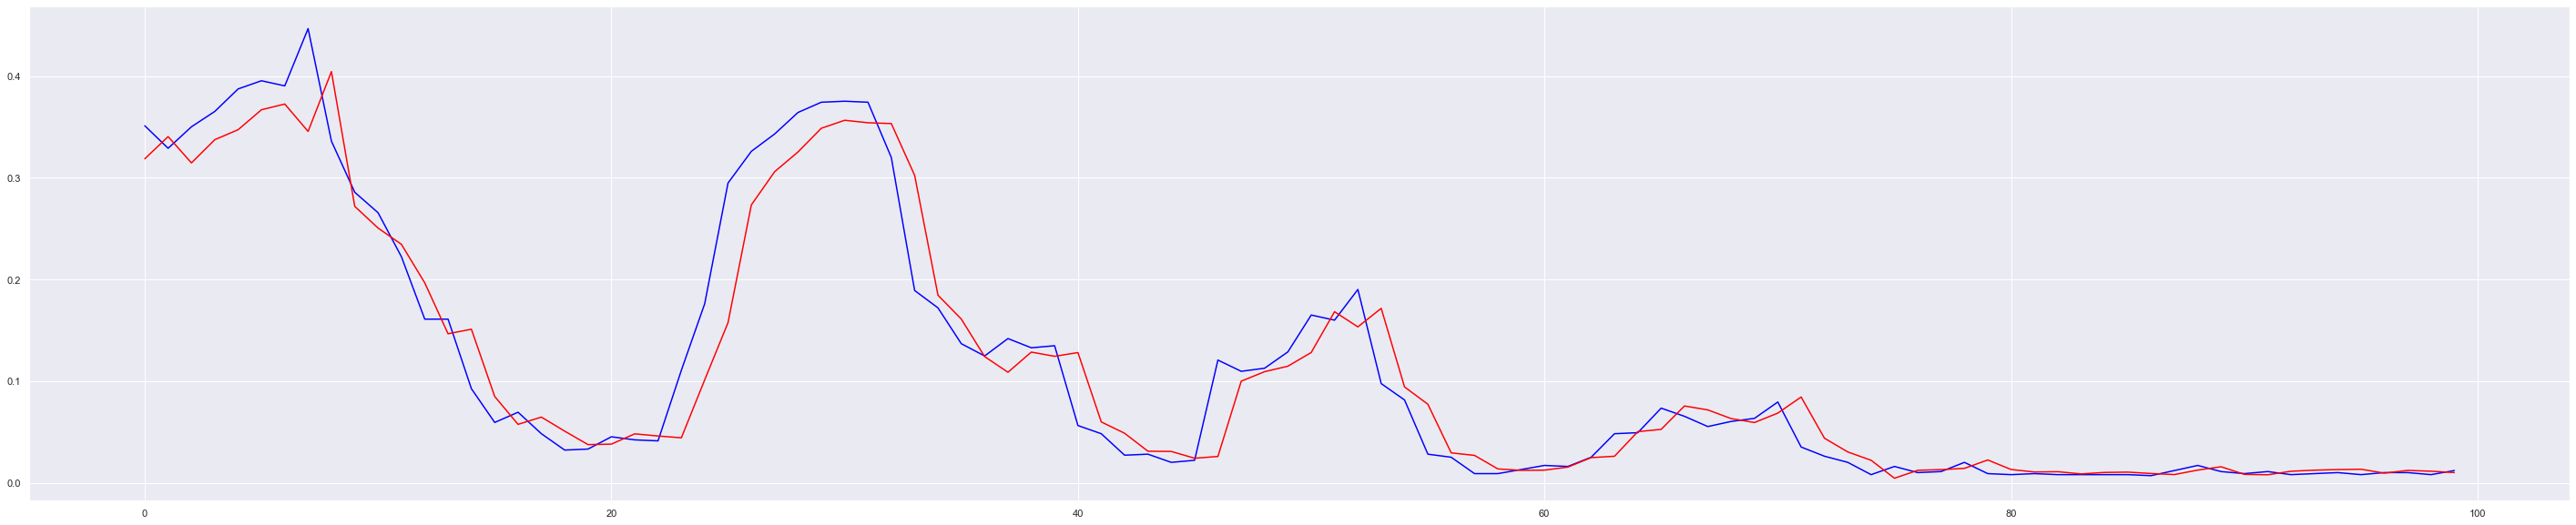

In [83]:
#validacion de resultados de manera grafica
plt.figure(figsize=(50,10))
plt.plot(y_test[-100:],color="blue")
plt.plot(y_pred[-100:],color="red")

In [87]:
#esta es una grafica que no tiene mucho sentido debido a que lo agregamos caracteristicas temporales
result=pd.DataFrame({
    "Y true":y_test.flatten(),
    "Y pred":y_pred.flatten()
    },
    index=test_index[:-24]
)


In [88]:
result.head()

,Y true,Y pred
Date,,
2014-01-01 00:00:00,0.144869,0.107664
2014-01-01 01:00:00,0.171026,0.136007
2014-01-01 02:00:00,0.175050,0.160667
2014-01-01 03:00:00,0.175050,0.169402
2014-01-01 04:00:00,0.173038,0.169494


<AxesSubplot:xlabel='Date'>

<Figure size 3600x720 with 0 Axes>

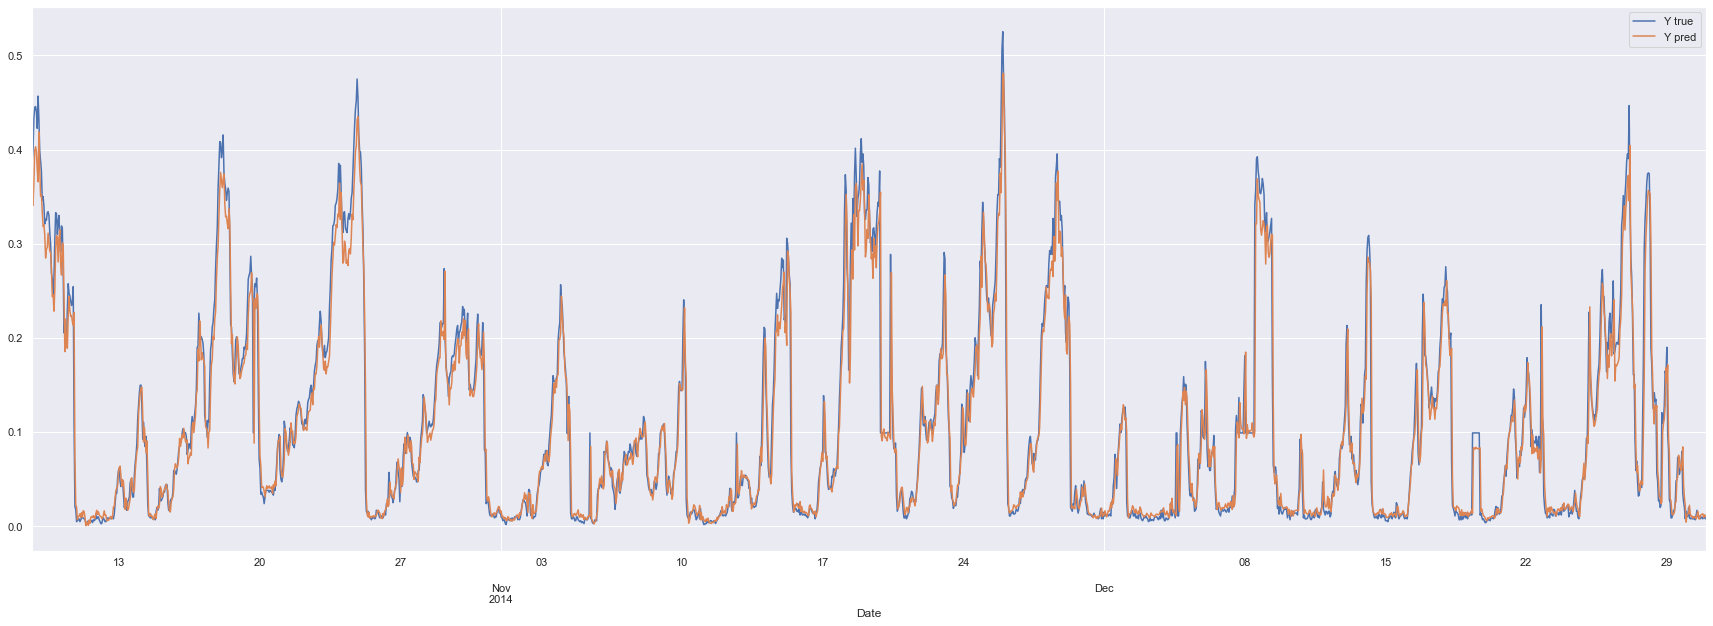

In [98]:
plt.figure(figsize=(50,10))
result.tail(2000).plot(figsize=(30,10))

In [95]:
model_lstm.save("lstm_predict_ppm")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lstm_predict_ppm\assets


In [99]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTMx64 (LSTM)               (None, 24, 64)            19456     
_________________________________________________________________
DROPOUTx1 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
LSTMx32 (LSTM)               (None, 32)                12416     
_________________________________________________________________
DROPOUTx2 (Dropout)          (None, 32)                0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 33        
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________


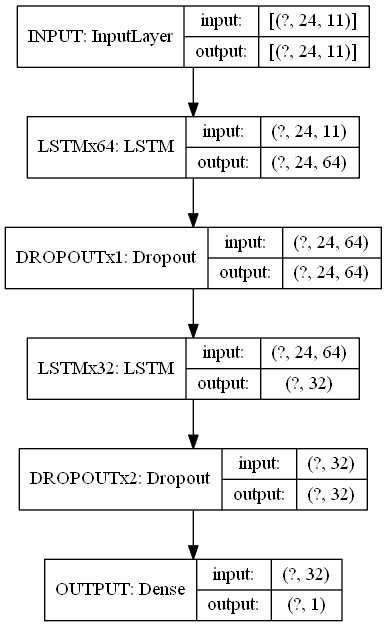

In [100]:
plot_model(model_lstm,show_shapes=True)

In [115]:
scaler_obj=MinMaxScaler(feature_range=(0,1))
scaler_obj.fit(data.loc[:"2014-01-01 00:00:00",["pm2.5"]]);


In [120]:
result=pd.DataFrame({
    "Y true":scaler_obj.inverse_transform(y_test).flatten(),
    "Y pred":scaler_obj.inverse_transform(y_pred).flatten()
    },
    index=test_index[:-24]
)

In [125]:
result.head()

,Y true,Y pred
Date,,
2014-01-01 00:00:00,144.0,107.017822
2014-01-01 01:00:00,170.0,135.190933
2014-01-01 02:00:00,174.0,159.702667
2014-01-01 03:00:00,174.0,168.385925
2014-01-01 04:00:00,172.0,168.476791


<AxesSubplot:xlabel='Date'>

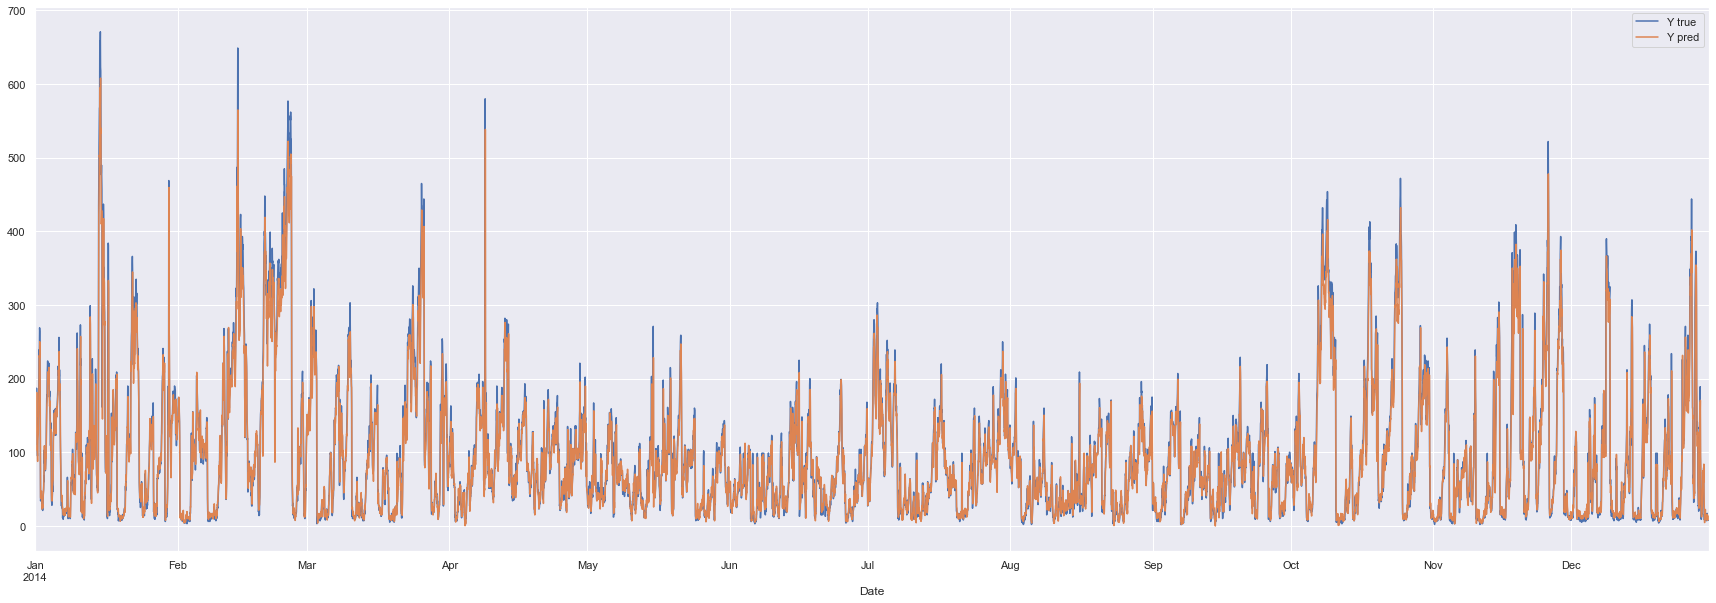

In [122]:
result.plot(figsize=(30,10))

In [123]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred)

0.0005629798939450864

In [126]:
mean_squared_error(result["Y true"],result["Y pred"])

556.2443966363305

In [ ]:
result.head()